<a href="https://colab.research.google.com/github/ms624atyale/PictureBook_Archive_inProgress/blob/main/Word2Vec_Berenstain_9Copies_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original Column Names: ['text', 'title', 'year_published', 'episode', 'grouping']
Standardized Column Names: ['text', 'title', 'year_published', 'episode', 'grouping']
Successfully loaded 9 text entries from 'text' column.
Word2Vec model training completed.

Semantically Related Word Pairs:
brother - papa: Similarity = 0.6432
brother - papa: Similarity = 0.6432
papa - sister: Similarity = 0.6343
papa - sister: Similarity = 0.6343
mama - papa: Similarity = 0.6293
mama - papa: Similarity = 0.6293
bear - papa: Similarity = 0.6219
bear - papa: Similarity = 0.6219
bear - thought: Similarity = 0.6166
bear - thought: Similarity = 0.6166
said - sister: Similarity = 0.6070
said - sister: Similarity = 0.6070
cubs - great: Similarity = 0.6066
cubs - great: Similarity = 0.6066
bear - mama: Similarity = 0.6065
bear - mama: Similarity = 0.6065
papa - said: Similarity = 0.6052
papa - said: Similarity = 0.6052
day - papa: Similarity = 0.5975
brother - sister: Similarity = 0.5957
brother - sister: Simi

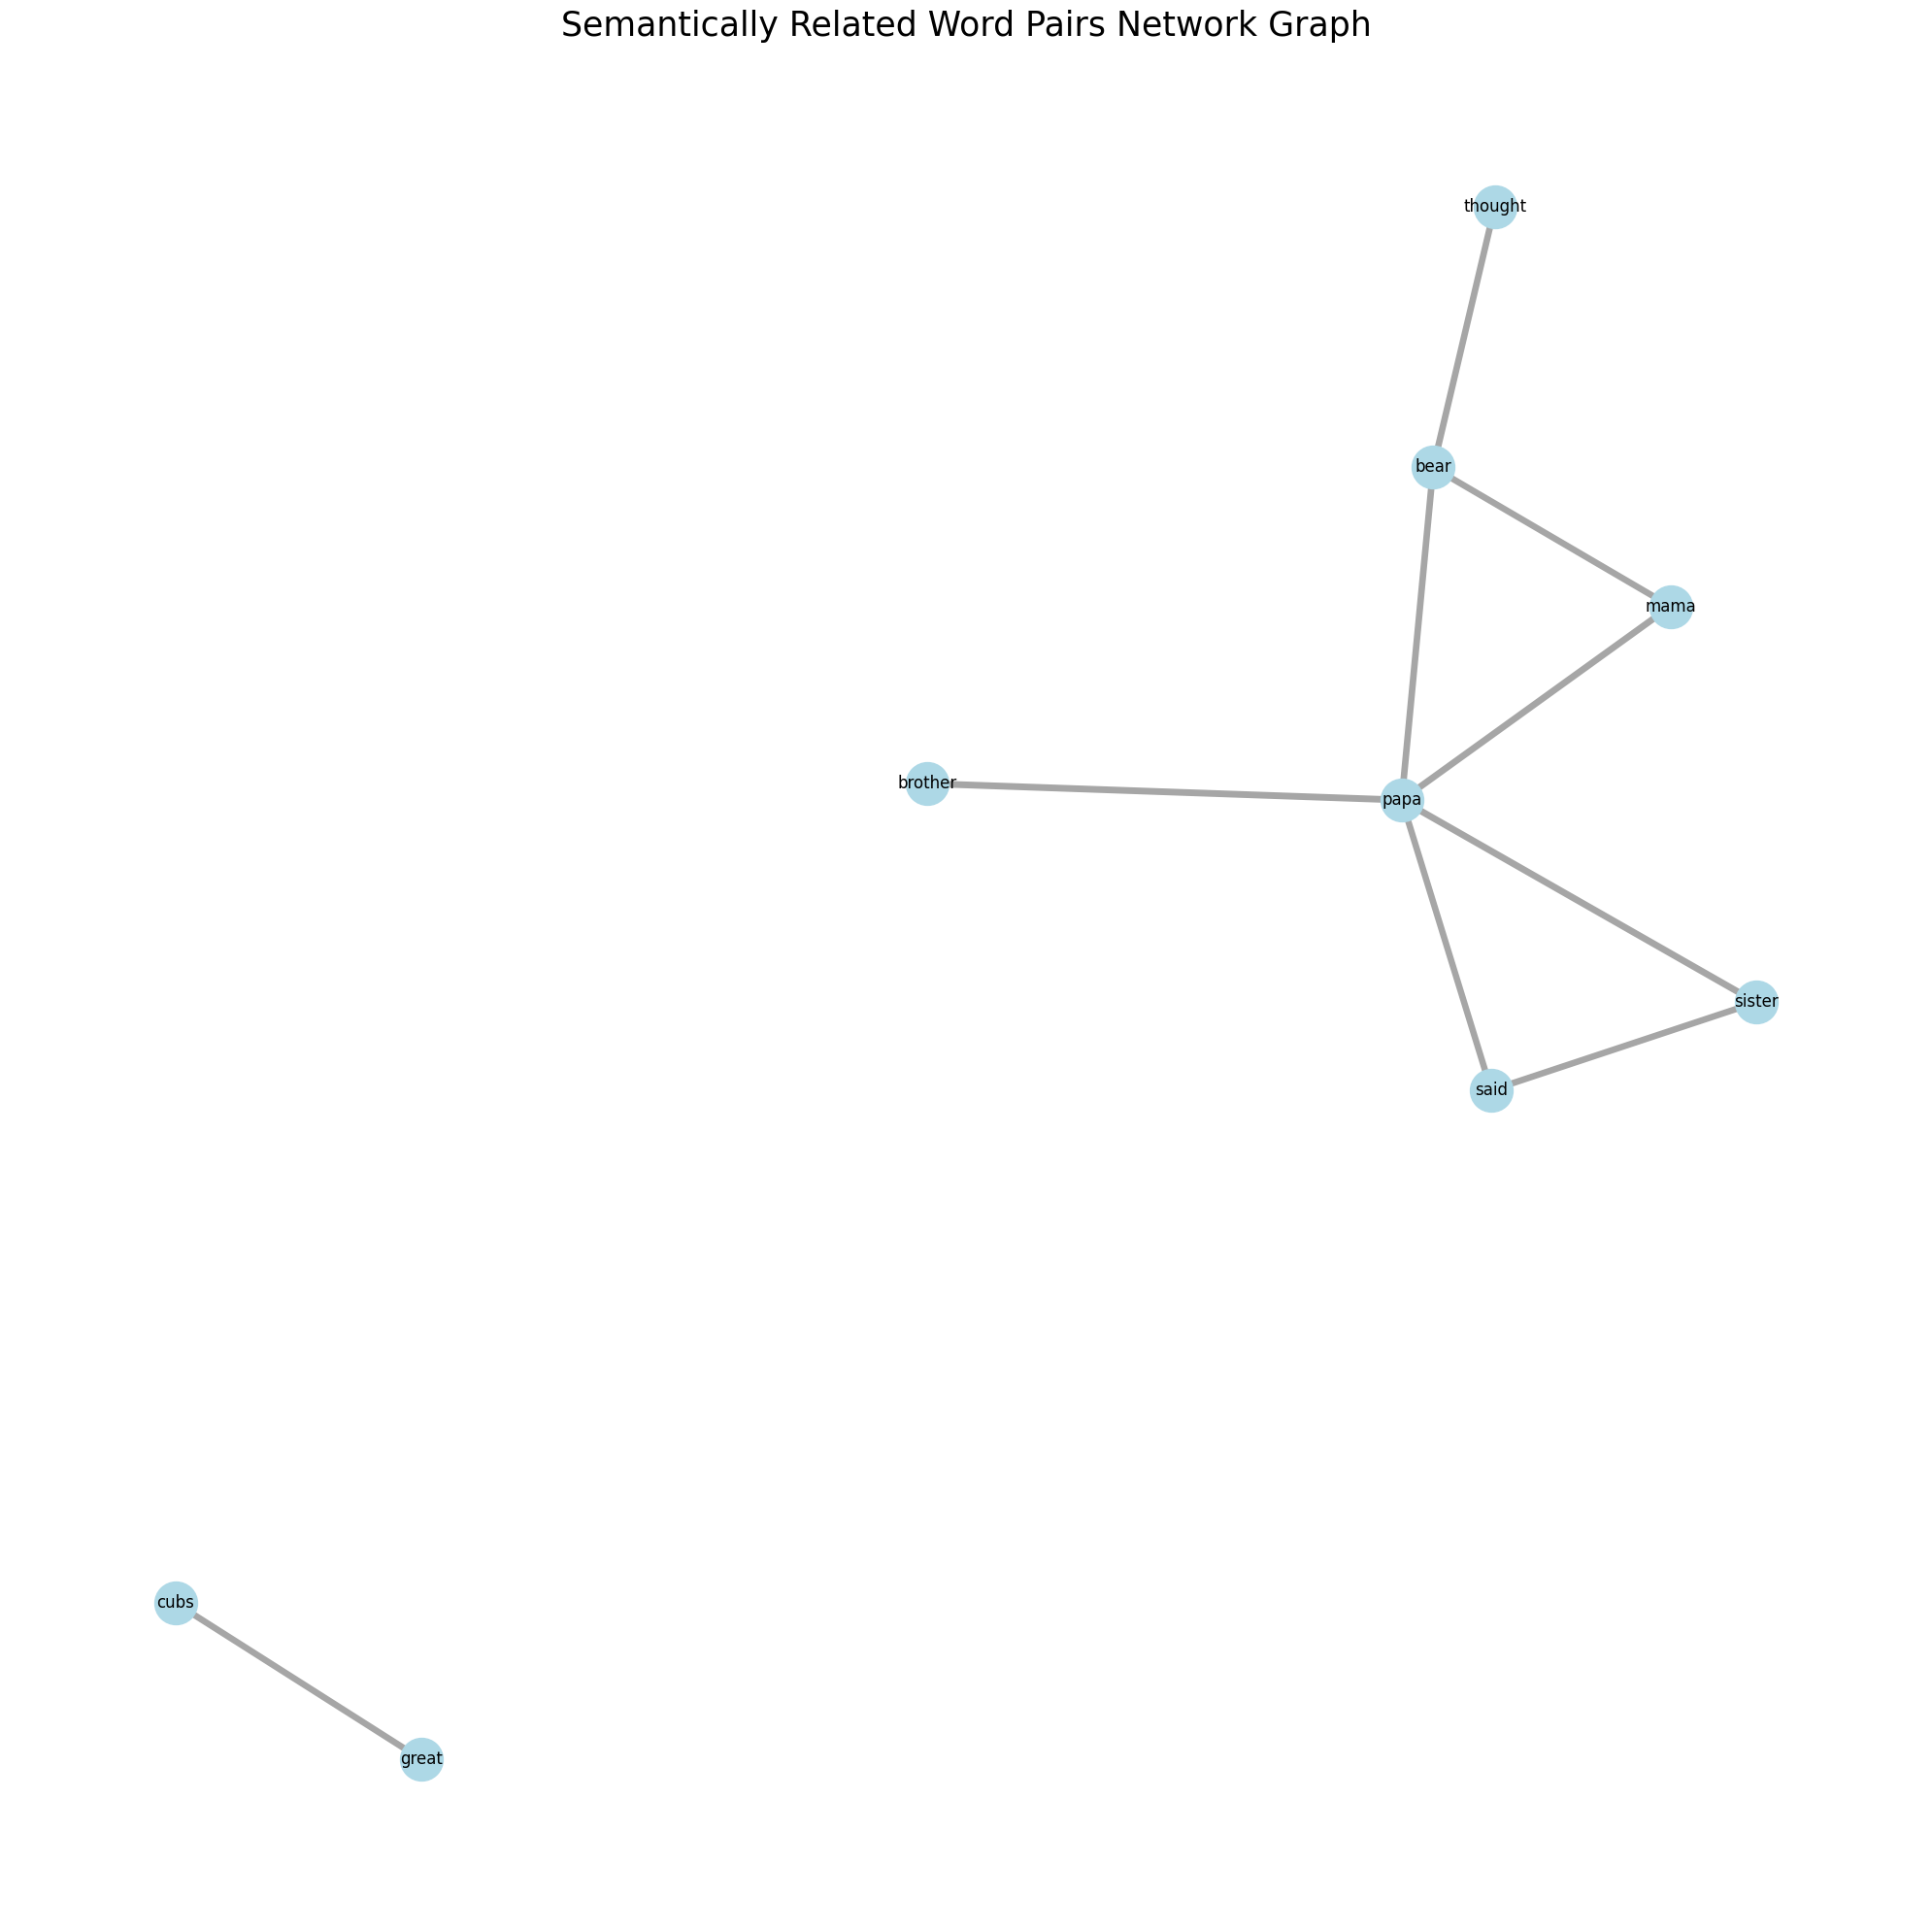

In [6]:
!pip install gensim

import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        df = pd.read_csv(file_path)
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text with Stopword Removal and POS Filtering
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word not in stop_words and word.isalpha() and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    stop_words = set(stopwords.words('english'))

    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for similar_word, similarity in similar_words:
            if similar_word in stop_words:
                continue
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold. Adjust the threshold and try again.")
        return

    pos = nx.spring_layout(G, k=0.5, iterations=50)
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]

    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Network graph saved to '{save_path}'.")

    plt.show()

# Step 6: Main Function
def main():
    file_path = "/content/BerenstainBears_First9Copies_BodyTitleYear.csv" #🍎🍎🍎🍎🍎
    text_column = "text"  #🍏🍏🍏🍏🍏

    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    sentences = preprocess_text_with_pos(text_list)
    model = train_word2vec_model(sentences)
    top_n = 50
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    print("\nSemantically Related Word Pairs:")
    for pair in related_word_pairs:
        print(f"{pair[0]} - {pair[1]}: Similarity = {pair[2]:.4f}")

    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])
    output_file = "/content/semantically_related_word_pairs.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    print("\nGenerating network graph...")
    similarity_threshold = 0.6
    generate_network_graph(related_word_pairs, similarity_threshold=similarity_threshold, save_path="/content/semantically_related_word_pairs_graph.png")

if __name__ == "__main__":
    main()